In [1]:
import re

from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

from tqdm import tqdm
import operator

import networkx as nx
import matplotlib.pyplot as plt

Data preprocessing

In [2]:
def clean_text(text):
    cleaned_text = re.sub('[^ ㄱ-ㅣ가-힣]+',' ',text) # 한국어, 스페이스바를 제외한 모든 문자 제거
    cleaned_text = ' '.join(cleaned_text.split()) # 너무 많은 공백이 생기므로 공백 1개로
    return cleaned_text

def get_nouns(text):
    okt = Okt() # 형태소 분석기
    nouns = okt.nouns(text) # 명사 추출
    nouns = [word for word in nouns if not (word in stopwords)] # 불용어 제거
    nouns = [word for word in nouns if len(word)>1] # 길이가 1 이상만 추출
    return nouns

In [3]:
def clean_tokenizing(data):
    data = data.dropna() # 결측값 제거
    data['내용'] = data['내용'].apply(lambda x: clean_text(x)) # 한국어만 추출
    data['명사'] = data['내용'].apply(lambda x: get_nouns(x)) # 명사만 추출
    
    drop_index_list = [] # 지워버릴 index를 담는 리스트
    for i, row in data.iterrows():
        temp_nouns = row['명사']
        if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
            drop_index_list.append(i) # 지울 index 추가
    data = data.drop(drop_index_list) # 해당 index를 지우기
    data.index = range(len(data))
    return data

In [4]:
def mk_tfidf(data):
    cv = CountVectorizer(max_features=4000, tokenizer=get_nouns) # data의 tf-idf 구축, tokenizer로 get_nouns 사용
    tdm = cv.fit_transform(data['내용']) # 위의 파라미터 수에 맞게 tdm 생성
    dataset = pd.DataFrame(data=tdm.todense(),columns=cv.get_feature_names())
    return dataset

In [5]:
def mk_input(tf_idf):
    column_list = list(tf_idf.columns)
    word_length = len(column_list)

    # 각 단어쌍의 빈도수를 저장할 dictionary 생성
    count_dict = {}

    for doc_number in tqdm(range(len(tf_idf)), desc='단어쌍 만들기 진행중'):
        tmp = tf_idf.loc[doc_number]           # 현재 문서의 단어 출현 빈도 데이터를 가져온다.
        for i, word1 in enumerate(column_list):
            if tmp[word1]:              # 현재 문서에 첫번째 단어가 존재할 경우
                for j in range(i + 1, word_length):
                    if tmp[column_list[j]]:              # 현재 문서에 두번째 단어가 존재할 경우
                        count_dict[column_list[i], column_list[j]] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

    # count_list에 word1, word2, frequency 형태로 저장할 것이다.
    count_list = []

    for words in count_dict:
        count_list.append([words[0], words[1], count_dict[words]])

    # 단어쌍 동시 출현 빈도를 DataFrame 형식으로 만든다.
    df = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
    df = df.sort_values(by=['freq'], ascending=False)
    df = df.reset_index(drop=True)
    return df

감성사전에 따른 가중치 추가해야함

In [55]:
def draw(df, keyword, length):
    font_family='NanumSquareRound'
    print(keyword, length)
    dataset = df[df['word1']==keyword]

    G_centrality = nx.Graph()

    # 빈도수가 20000 이상인 단어쌍에 대해서만 edge(간선)을 표현한다.
    for ind in list(dataset.index)[:length]:
        G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight=int(dataset['freq'][ind]))

    dgr = nx.degree_centrality(G_centrality)        # 연결 중심성
    btw = nx.betweenness_centrality(G_centrality)   # 매개 중심성
    cls = nx.closeness_centrality(G_centrality)     # 근접 중심성
    egv = nx.eigenvector_centrality(G_centrality)   # 고유벡터 중심성
    pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

    sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
    sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
    sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
    sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
    sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

    G = nx.Graph()
    
    for i in range(len(sorted_pgr)): # 페이지 랭크에 따른 노드 추가
        G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1],color='r')

    for ind in list(dataset.index)[:length]: # 
        G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])
        
    words = list(G.nodes)
    sent_points = []
    word_points = {}
    for word in words:
        try:
            sent_point = float(sent[sent['단어'] == word]['points'].values)
            word_points[word] = sent_point
            sent_points.append(sent_point)
        except:
            word_points[word] = 0
            sent_points.append(0) 
    
    #colors = list(r)

    # 노드 크기 조정
    sizes = [G.nodes[node]['nodesize'] * 5000+1000 for node in G] 

    # 옵션
    options = {
        'edge_color': '#000000',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
        'cmap' : 'coolwarm',
        'node_color' : sent_points,
        'alpha' : 0.5
    }


    plt.figure(figsize=(8,5))
    nx.draw(G, node_size=sizes,
            pos=nx.spring_layout(G, k=3.5, iterations=100), **options, font_family=font_family)  # font_family로 폰트 등록
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")
    plt.show()
    return word_points

연관 출현 빈도 분석결과 저장시

In [23]:
file_path='C:/Users/hyunsoo/study/ds_project/crawler/박채희/crawler/환경오염.csv' # 파일 수정필요
stopwords_path = './data/stopwords.txt'
sent = pd.read_csv('./data/dict.csv',encoding='cp949')
with open(stopwords_path,'r') as op:
    stopwords = op.readlines()
    stopwords = stopwords[0].split(',')

data = pd.read_csv(file_path, encoding='cp949',index_col = 0)
data = clean_tokenizing(data)
tf_idf = mk_tfidf(data)
words_freq = mk_input(tf_idf)
words_freq.to_csv('data/words_freq.csv',encoding='cp949')

단어쌍 만들기 진행중: 100%|████████████████████████████████████████████████████████| 1105/1105 [10:33<00:00,  1.74it/s]


코인 10


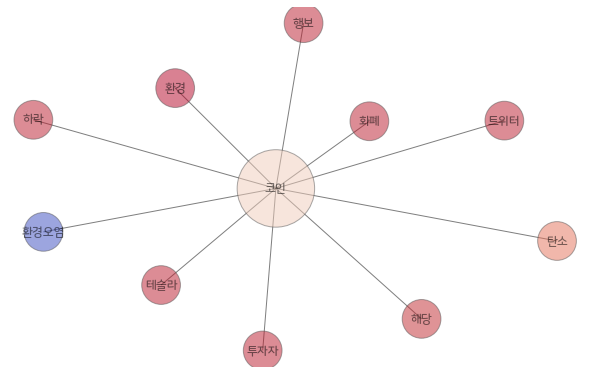

{'코인': -0.4003071999232327, '화폐': 0, '환경': 0.0234662641354019, '테슬라': 0.0034647694741412, '환경오염': -1.0, '트위터': 0, '행보': 0, '투자자': 0, '하락': 0, '해당': -0.0106338073469777, '탄소': -0.1393769576330001}


In [59]:
words_freq = pd.read_csv('./data/words_freq.csv',encoding='cp949')
print(draw(words_freq,'코인',10))

C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


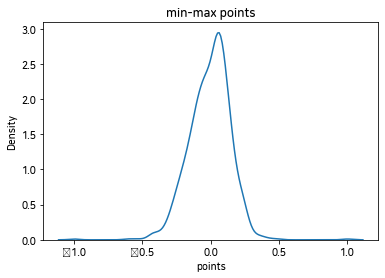

In [47]:
import seaborn as sns

sns.kdeplot(sent['points'])
plt.title('min-max points')
plt.show()

<AxesSubplot:xlabel='회귀계수', ylabel='Density'>

C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


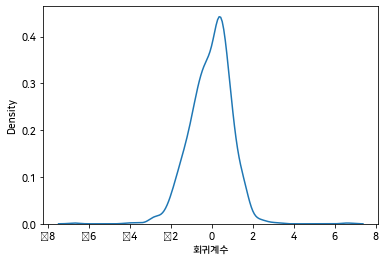

In [48]:
sns.kdeplot(sent['회귀계수']/sent['회귀계수'].std())